In [1]:
!pip install pandas matplotlib seaborn wordcloud nltk

You should consider upgrading via the '/Users/navyaagarwal/Desktop/random/marketplace-ml-optimization/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# =========================
# IMPORT LIBRARIES
# =========================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from pathlib import Path

sns.set(style="whitegrid")

In [3]:
import nltk

In [85]:
# =========================
# LOAD CLEAN DATA
# =========================
data_folder = Path('/Users/navyaagarwal/Desktop/random/marketplace-ml-optimization/data')
eda_path = os.path.join(data_folder, "clean_data")

orders_master = pd.read_csv(os.path.join(eda_path, "orders_master.csv"))
customers = pd.read_csv(os.path.join(eda_path, "customers.csv"))
order_items = pd.read_csv(os.path.join(eda_path, "order_items.csv"))
order_payments = pd.read_csv(os.path.join(eda_path, "order_payments.csv"))
order_reviews = pd.read_csv(os.path.join(eda_path, "order_reviews.csv"))
orders = pd.read_csv(os.path.join(eda_path, "orders.csv"))
products = pd.read_csv(os.path.join(eda_path, "products.csv"))
sellers = pd.read_csv(os.path.join(eda_path, "sellers.csv"))

In [86]:
# Aggregate payments
payment_agg = order_payments.groupby("order_id")["payment_value"].sum().reset_index()

# Aggregate item price + freight
items_agg = order_items.groupby("order_id").agg({
    "price": "sum",
    "freight_value": "sum"
}).reset_index()

items_agg["total_price_freight"] = items_agg["price"] + items_agg["freight_value"]

# Merge
payment_compare = payment_agg.merge(items_agg, on="order_id", how="inner")

payment_compare["difference"] = (
    payment_compare["payment_value"] -
    payment_compare["total_price_freight"]
)

# Negative revenue stats
negative_orders = payment_compare[payment_compare["difference"] < 0]

print("Negative Orders:", len(negative_orders))
print("Total Negative Revenue:", negative_orders["difference"].sum())
print("Share of Orders:", len(negative_orders) / len(payment_compare))

Negative Orders: 9716
Total Negative Revenue: -200.78000000022638
Share of Orders: 0.09847463639588507


In [87]:
meaningful_neg = payment_compare[payment_compare["difference"] < -1]

print("Meaningful Negative Orders:", len(meaningful_neg))
print("Total Meaningful Negative Revenue:", meaningful_neg["difference"].sum())

Meaningful Negative Orders: 17
Total Meaningful Negative Revenue: -197.57


In [88]:
order_payments["payment_type"].value_counts(normalize=True)

order_payments.groupby("payment_type")["payment_value"].sum().sort_values(ascending=False)

payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64

In [89]:
orders_master["freight_ratio"] = (
    orders_master["total_freight"] /
    orders_master["total_price"]
)

orders_master["freight_ratio"].describe()

count    98666.000000
mean         0.308389
std          0.314762
min          0.000000
25%          0.131864
50%          0.224374
75%          0.380191
max         21.447059
Name: freight_ratio, dtype: float64

In [90]:
high_freight = orders_master[orders_master["freight_ratio"] > 0.5]

print("High Freight Orders:", len(high_freight))
print("Revenue Impact:", high_freight["total_price"].sum())

High Freight Orders: 15610
Revenue Impact: 556035.0


In [91]:
pd.qcut(orders_master["total_price"], 5)
orders_master.groupby(
    pd.qcut(orders_master["total_price"], 5)
)["freight_ratio"].mean()

/var/folders/s8/422ypdc50wl56c902xtkhn000000gn/T/ipykernel_20765/2099573974.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_master.groupby(


total_price
(0.849, 39.0]        0.670692
(39.0, 67.99]        0.334078
(67.99, 107.0]       0.234463
(107.0, 176.96]      0.182396
(176.96, 13440.0]    0.117663
Name: freight_ratio, dtype: float64

In [92]:
category_data = order_items.merge(
    products[["product_id", "product_category_name"]],
    on="product_id",
    how="left"
)

category_data.groupby("product_category_name")["freight_value"].mean().sort_values(ascending=False)

product_category_name
computers                                  48.454680
home_appliances_2                          44.538571
furniture_mattress_and_upholstery          42.906842
kitchen_dining_laundry_garden_furniture    42.702598
furniture_bedroom                          42.497523
                                             ...    
food                                       14.256922
home_comfort_2                             13.677000
fashio_female_clothing                     12.953125
books_imported                             12.830833
fashion_childrens_clothes                  11.938750
Name: freight_value, Length: 71, dtype: float64

In [93]:
sellers.head()

,seller_id,latitude,longitude
0,3442f8959a84dea7ee197c632cb2df15,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,-22.964803,-46.534419


In [94]:
customers.head()

,customer_id,customer_unique_id,latitude,longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,-22.975100,-47.142925


In [95]:
orders_master = orders_master.merge(
    customers[["customer_id", "latitude", "longitude"]],
    on="customer_id",
    how="left"
)

orders_master.rename(columns={
    "latitude": "customer_lat",
    "longitude": "customer_lng"
}, inplace=True)

In [96]:
order_seller = order_items.groupby("order_id")["seller_id"].first().reset_index()

orders_master = orders_master.merge(order_seller, on="order_id", how="left")

orders_master = orders_master.merge(
    sellers[["seller_id", "latitude", "longitude"]],
    on="seller_id",
    how="left"
)

orders_master.rename(columns={
    "latitude": "seller_lat",
    "longitude": "seller_lng"
}, inplace=True)

In [97]:
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # km
    
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

orders_master["distance_km"] = haversine_vectorized(
    orders_master["customer_lat"],
    orders_master["customer_lng"],
    orders_master["seller_lat"],
    orders_master["seller_lng"]
)

In [98]:
orders_master["distance_km"].describe()

count    98175.000000
mean       601.654691
std        595.200118
min          0.000000
25%        185.722082
50%        433.792048
75%        799.336216
max       8677.911622
Name: distance_km, dtype: float64

In [99]:
orders_master[["distance_km", "freight_ratio"]].corr()

,distance_km,freight_ratio
distance_km,1.000000,0.197922
freight_ratio,0.197922,1.000000


In [100]:
orders_master.groupby(
    pd.qcut(orders_master["distance_km"], 5)
)["freight_ratio"].mean()

/var/folders/s8/422ypdc50wl56c902xtkhn000000gn/T/ipykernel_20765/2023238695.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_master.groupby(


distance_km
(-0.001, 115.634]      0.228332
(115.634, 347.996]     0.270986
(347.996, 529.807]     0.310426
(529.807, 877.283]     0.329405
(877.283, 8677.912]    0.402647
Name: freight_ratio, dtype: float64

In [101]:
# orders_master = pd.read_csv(os.path.join(eda_path, "orders_master.csv"))
# customers = pd.read_csv(os.path.join(eda_path, "customers.csv"))
# order_items = pd.read_csv(os.path.join(eda_path, "order_items.csv"))
# order_payments = pd.read_csv(os.path.join(eda_path, "order_payments.csv"))
# order_reviews = pd.read_csv(os.path.join(eda_path, "order_reviews.csv"))
# orders = pd.read_csv(os.path.join(eda_path, "orders.csv"))
# products = pd.read_csv(os.path.join(eda_path, "products.csv"))
# sellers = pd.read_csv(os.path.join(eda_path, "sellers.csv"))

print("===============================================================================================================")
print("orders_master table:")
print(orders_master.head())
print("===============================================================================================================")

print("customers table:")
print(customers.head())
print("===============================================================================================================")

print("order_items table:")
print(order_items.head())
print("===============================================================================================================")

print("order_payments table:")
print(order_payments.head())
print("===============================================================================================================")

print("order_reviews table:")
print(order_reviews.head())
print("===============================================================================================================")

print("orders table:")
print(orders.head())
print("===============================================================================================================")

print("products table:")
print(products.head())
print("===============================================================================================================")

print("sellers table:")
print(sellers.head())
print("===============================================================================================================")

orders_master table:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31

In [102]:
# Compute product volume (cm³)
products['product_volume_cm3'] = (
    products['product_length_cm'] *
    products['product_height_cm'] *
    products['product_width_cm']
)

# Merge dimensions into order_items
order_items_enriched = order_items.merge(
    products[['product_id', 'product_weight_g', 'product_volume_cm3']],
    on='product_id',
    how='left'
)

# Aggregate dimensions at order level
order_dim_agg = order_items_enriched.groupby('order_id').agg({
    'product_weight_g': 'sum',
    'product_volume_cm3': 'sum'
}).reset_index()

# Merge into orders_master
orders_master = orders_master.merge(order_dim_agg, on='order_id', how='left')

In [103]:
date_cols = [
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_cols:
    orders_master[col] = pd.to_datetime(orders_master[col], errors='coerce')

# Delivery days: actual delivery time
orders_master['delivery_days'] = (
    orders_master['order_delivered_customer_date'] -
    orders_master['order_purchase_timestamp']
).dt.days

# Expected days: promised delivery window
orders_master['expected_days'] = (
    orders_master['order_estimated_delivery_date'] -
    orders_master['order_purchase_timestamp']
).dt.days

# Late days: how late (positive = late, negative = early)
orders_master['late_days'] = (
    orders_master['order_delivered_customer_date'] -
    orders_master['order_estimated_delivery_date']
).dt.days

# Late flag
orders_master['is_late'] = orders_master['late_days'] > 0

orders_master = orders_master[
    orders_master['order_status'] == 'delivered'
].copy()


print(orders_master[['delivery_days','expected_days','late_days','is_late']].describe())
print(orders_master['is_late'].mean())

       delivery_days  expected_days     late_days
count   96470.000000   96478.000000  96470.000000
mean       12.093604      23.372759    -11.875889
std         9.551380       8.758137     10.182105
min         0.000000       2.000000   -147.000000
25%         6.000000      18.000000    -17.000000
50%        10.000000      23.000000    -12.000000
75%        15.000000      28.000000     -7.000000
max       209.000000     155.000000    188.000000
0.0677252845208234


In [104]:
# Select relevant columns
distance_analysis = orders_master[[
    'distance_km',
    'delivery_days',
    'expected_days',
    'late_days',
    'is_late',
    'product_weight_g',
    'product_volume_cm3'
]].dropna()

# Correlation matrix
corr_matrix = distance_analysis.corr(numeric_only=True)
print(corr_matrix)

                    distance_km  delivery_days  expected_days  late_days  \
distance_km            1.000000       0.393572       0.515507  -0.074438   
delivery_days          0.393572       1.000000       0.383061   0.607135   
expected_days          0.515507       0.383061       1.000000  -0.500072   
late_days             -0.074438       0.607135      -0.500072   1.000000   
is_late                0.076472       0.603305      -0.033390   0.595006   
product_weight_g      -0.009131       0.071451       0.075147   0.002717   
product_volume_cm3    -0.012439       0.062822       0.065878   0.002718   

                     is_late  product_weight_g  product_volume_cm3  
distance_km         0.076472         -0.009131           -0.012439  
delivery_days       0.603305          0.071451            0.062822  
expected_days      -0.033390          0.075147            0.065878  
late_days           0.595006          0.002717            0.002718  
is_late             1.000000          0.019289

In [105]:
orders_master['distance_bucket'] = pd.qcut(
    orders_master['distance_km'], 5, labels=False
)

late_by_distance = orders_master.groupby('distance_bucket')['is_late'].mean()
print(late_by_distance)

distance_bucket
0.0    0.045365
1.0    0.057656
2.0    0.065937
3.0    0.072083
4.0    0.096979
Name: is_late, dtype: float64


In [106]:
order_price_agg = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()

orders_master = orders_master.merge(order_price_agg, on='order_id', how='left')

In [107]:
distance_price_corr = orders_master[[
    'distance_km',
    'price',
    'freight_value'
]].corr()

print(distance_price_corr)

               distance_km     price  freight_value
distance_km       1.000000  0.079989       0.314905
price             0.079989  1.000000       0.411176
freight_value     0.314905  0.411176       1.000000


In [108]:
orders_master['freight_per_km'] = (
    orders_master['freight_value'] /
    orders_master['distance_km'].replace(0, np.nan)
)

print(orders_master[['distance_km','freight_value','freight_per_km']].describe())

        distance_km  freight_value  freight_per_km
count  96000.000000   96478.000000    95977.000000
mean     600.729517      22.785253        0.185467
std      593.699158      21.559197        0.953465
min        0.000000       0.000000        0.000000
25%      185.891815      13.850000        0.026064
50%      433.846541      17.170000        0.043834
75%      798.491136      24.017500        0.101297
max     8677.911622    1794.960000      151.604741


In [109]:
payment_distribution = order_payments['payment_type'].value_counts(normalize=True)
print(payment_distribution)

payment_type
credit_card    0.739224
boleto         0.190440
voucher        0.055590
debit_card     0.014718
not_defined    0.000029
Name: proportion, dtype: float64


In [110]:
payment_revenue = order_payments.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)
print(payment_revenue)

payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64


In [111]:
reviews_enriched = order_reviews.merge(
    orders_master[['order_id', 'is_late', 'late_days']],
    on='order_id',
    how='left'
)

In [112]:
review_distribution = reviews_enriched['review_score'].value_counts(normalize=True)
print(review_distribution)

review_score
5    0.577763
4    0.192917
1    0.115133
3    0.082430
2    0.031756
Name: proportion, dtype: float64


In [113]:
late_vs_review = reviews_enriched.groupby('is_late')['review_score'].mean()
print(late_vs_review)

is_late
False    4.289999
True     2.271025
Name: review_score, dtype: float64


In [114]:
len(reviews_enriched)

99224

In [115]:
total = len(reviews_enriched)

non_null = reviews_enriched['review_comment_message'].notna().sum()

non_empty = (
    reviews_enriched['review_comment_message']
    .fillna("")
    .str.strip() != ""
).sum()

print(f"Total rows: {total}")
print(f"Non-null reviews: {non_null}")
print(f"Non-empty reviews: {non_empty}")
print(f"Empty or missing: {total - non_empty}")

Total rows: 99224
Non-null reviews: 40977
Non-empty reviews: 40950
Empty or missing: 58274


In [116]:
non_empty_reviews = reviews_enriched[
    reviews_enriched['review_comment_message']
        .fillna("")
        .str.strip() != ""
]['review_comment_message']

total_characters = non_empty_reviews.str.len().sum()

print("Total characters:", total_characters)

Total characters: 2812497


In [117]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

reviews_enriched['review_comment_message'] = reviews_enriched['review_comment_message'].fillna("")

reviews_enriched['sentiment_score'] = reviews_enriched['review_comment_message'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

reviews_enriched['sentiment_label'] = reviews_enriched['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

print(reviews_enriched['sentiment_label'].value_counts(normalize=True))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/navyaagarwal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment_label
neutral     0.922670
negative    0.046330
positive    0.031001
Name: proportion, dtype: float64


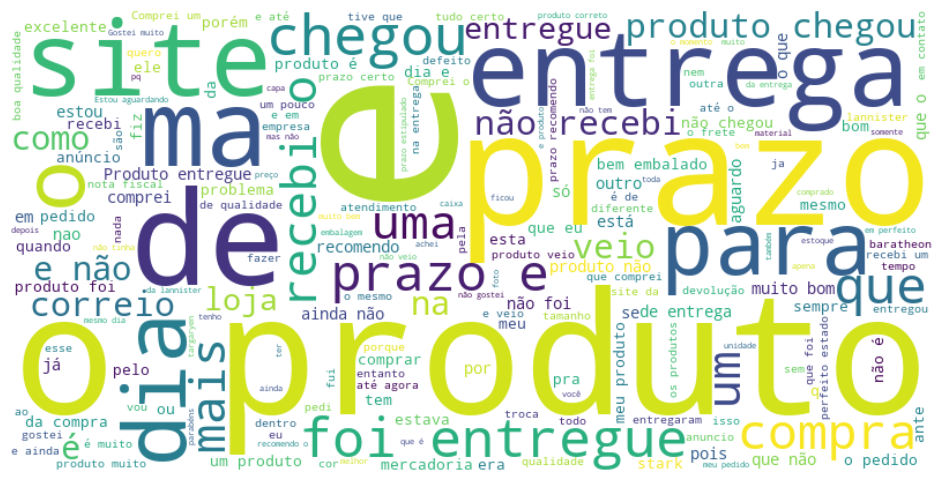

In [118]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_reviews = reviews_enriched[
    reviews_enriched['sentiment_label'] == 'negative'
]['review_comment_message']

text = " ".join(negative_reviews)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [119]:
from collections import Counter
import re

# Get all negative review text
negative_reviews = reviews_enriched[
    reviews_enriched['sentiment_label'] == 'negative'
]['review_comment_message']

# Combine all text into one string
text = " ".join(negative_reviews)

# Tokenize: split by word characters, lowercase everything
words = re.findall(r'\w+', text.lower())

# Count frequency of each word
word_counts = Counter(words)

# Get the 50 most common words
top_50_words = word_counts.most_common(50)

# Display nicely
for word, count in top_50_words:
    print(f"{word}: {count}")

no: 4746
o: 3272
e: 2986
produto: 2810
prazo: 2071
a: 2011
não: 1967
de: 1932
que: 1865
do: 1181
com: 921
foi: 910
entrega: 880
chegou: 880
entregue: 865
recebi: 843
um: 772
é: 766
muito: 749
da: 680
em: 662
para: 589
site: 588
mas: 584
dia: 558
comprei: 551
veio: 549
na: 529
uma: 465
compra: 429
bom: 401
eu: 392
recomendo: 386
bem: 379
mais: 378
como: 367
qualidade: 365
meu: 360
estou: 353
loja: 330
só: 328
ainda: 311
pedido: 295
mesmo: 278
por: 277
até: 266
me: 266
já: 258
as: 245
lannister: 245


In [120]:
category_df = order_items.merge(
    products[['product_id','product_category_name']],
    on='product_id',
    how='left'
)
category_orders = category_df.groupby('product_category_name')['order_id'].nunique().sort_values(ascending=False)
print(category_orders.head(20))
category_revenue = category_df.groupby('product_category_name')['price'].sum().sort_values(ascending=False)
print(category_revenue.head(20))

product_category_name
bed_bath_table              9417
health_beauty               8836
sports_leisure              7720
computers_accessories       6689
furniture_decor             6449
housewares                  5884
watches_gifts               5624
telephony                   4199
auto                        3897
toys                        3886
cool_stuff                  3632
garden_tools                3518
perfumery                   3162
baby                        2885
electronics                 2550
stationery                  2311
fashion_bags_accessories    1864
pet_shop                    1710
office_furniture            1273
consoles_games              1062
Name: order_id, dtype: int64
product_category_name
health_beauty            1258681.34
watches_gifts            1205005.68
bed_bath_table           1036988.68
sports_leisure            988048.97
computers_accessories     911954.32
furniture_decor           729762.49
cool_stuff                635290.85
housewares     

In [121]:
product_orders = order_items.groupby('product_id')['order_id'].nunique().reset_index(name='num_orders')
product_reviews = order_items.merge(order_reviews[['order_id']], on='order_id')
product_reviews = product_reviews.groupby('product_id')['order_id'].nunique().reset_index(name='num_reviews')
product_perf = products.merge(product_orders, on='product_id', how='left') \
                       .merge(product_reviews, on='product_id', how='left')

product_perf[['num_orders','num_reviews']] = product_perf[['num_orders','num_reviews']].fillna(0)
content_corr = product_perf[[
    'product_photos_qty',
    'product_description_lenght',
    'product_name_lenght',
    'num_orders',
    'num_reviews'
]].corr()

print(content_corr)

                            product_photos_qty  product_description_lenght  \
product_photos_qty                    1.000000                    0.108745   
product_description_lenght            0.108745                    1.000000   
product_name_lenght                   0.134321                    0.098741   
num_orders                            0.009663                    0.008182   
num_reviews                           0.009735                    0.008178   

                            product_name_lenght  num_orders  num_reviews  
product_photos_qty                     0.134321    0.009663     0.009735  
product_description_lenght             0.098741    0.008182     0.008178  
product_name_lenght                    1.000000    0.012798     0.012833  
num_orders                             0.012798    1.000000     0.999857  
num_reviews                            0.012833    0.999857     1.000000  


In [122]:
# pip install googletrans==4.0.0-rc1

In [123]:
# from googletrans import Translator
# translator = Translator()

# def translate_text(text):
#     try:
#         return translator.translate(text, src='pt', dest='en').text
#     except:
#         return ""

# # Translate only non-empty reviews
# reviews_enriched['review_comment_en'] = reviews_enriched[
#     'review_comment_message'
# ].apply(lambda x: translate_text(x) if x.strip() != "" else "")

# print(reviews_enriched[['review_comment_message','review_comment_en']].head())

# negative_reviews_en = reviews_enriched[
#     reviews_enriched['sentiment_label'] == 'negative'
# ]['review_comment_en']

# text = " ".join(negative_reviews_en)

In [145]:
import pandas as pd
import numpy as np

# =================================================================
# 1. CLEAN & SYNC BASE DATA
# =================================================================

# Deduplicate reviews first so we don't multiply rows during the merge
clean_reviews = order_reviews.sort_values('review_answer_timestamp', ascending=False) \
                             .drop_duplicates('order_id') \
                             [['order_id', 'review_score']]

# Prepare orders_master (Standardizing column names for Price and Freight)
orders_master = orders_master.rename(columns={
    'total_price': 'order_price',
    'total_freight': 'order_freight'
})

# Drop review_score if it exists to prevent suffixes (_x, _y), then merge clean version
if 'review_score' in orders_master.columns:
    orders_master = orders_master.drop(columns=['review_score'])
orders_master = orders_master.merge(clean_reviews, on='order_id', how='left')

# Calculate Margin and Lateness at the order level
orders_master['margin_proxy'] = orders_master['order_price'] - orders_master['order_freight']
orders_master['is_late'] = (
    pd.to_datetime(orders_master['order_delivered_customer_date']) > 
    pd.to_datetime(orders_master['order_estimated_delivery_date'])
).astype(int)

# Fill missing reviews with median so correlations don't break
orders_master['review_score'] = orders_master['review_score'].fillna(orders_master['review_score'].median())

# =================================================================
# 2. FULL ORDERS JOIN (For Person-Level Analysis)
# =================================================================

# We merge orders with customers to get the REAL person ID (customer_unique_id)
full_orders = orders_master.merge(
    customers[['customer_id', 'customer_unique_id']], 
    on='customer_id', 
    how='left'
)

# =================================================================
# 3. STATISTICAL ANALYSES
# =================================================================

# --- 📈 1. Repeat Purchase Analysis (Person Level) ---
customer_behavior = full_orders.groupby('customer_unique_id').agg({
    'order_id': 'count',
    'is_late': 'mean',
    'review_score': 'mean'
}).rename(columns={'order_id': 'total_orders', 'is_late': 'late_rate', 'review_score': 'avg_review'})

print("\n--- 1. Repeat Purchase Stats (Using Unique Customer ID) ---")
print(f"Total Unique Customers: {len(customer_behavior)}")
print(f"Customers with 2+ Orders: {len(customer_behavior[customer_behavior['total_orders'] > 1])}")
print("\nCorrelation (Person Level):")
print(customer_behavior[['total_orders', 'late_rate', 'avg_review']].corr())

# --- ⭐ 2. Impact of Lateness on Reviews ---
late_vs_review = full_orders.groupby('is_late')['review_score'].mean()
print("\n--- 2. Average Review Score: On-Time (0) vs Late (1) ---")
print(late_vs_review)

# --- 💰 3. Category Margin Numbers ---
cat_analysis = order_items.merge(
    products[['product_id', 'product_category_name']], on='product_id', how='left'
).merge(
    full_orders[['order_id', 'margin_proxy', 'is_late', 'order_price', 'order_freight']], on='order_id', how='left'
)

print("\n--- 3. Margin & Lateness by Category (Top 10) ---")
cat_summary = cat_analysis.groupby('product_category_name').agg({
    'margin_proxy': 'mean',
    'is_late': 'mean'
}).sort_values('margin_proxy', ascending=False)
print(cat_summary.head(10))

# --- 🚚 4. Freight-to-Price Ratio (Worst Categories) ---
print("\n--- 4. Top 10 Highest Freight-to-Price Ratio Categories ---")
cat_ratio = cat_analysis.groupby('product_category_name').apply(
    lambda x: x['order_freight'].sum() / x['order_price'].sum() if x['order_price'].sum() > 0 else 0
).sort_values(ascending=False)
print(cat_ratio.head(10))

# --- 📉 5. Operational Correlation ---
print("\n--- 5. Operational Correlation Matrix ---")
op_cols = ['distance_km', 'is_late', 'order_freight', 'order_price', 'margin_proxy', 'review_score']
print(orders_master[op_cols].corr())


--- 1. Repeat Purchase Stats (Using Unique Customer ID) ---
Total Unique Customers: 93104
Customers with 2+ Orders: 2792

Correlation (Person Level):
              total_orders  late_rate  avg_review
total_orders      1.000000  -0.007114    0.009454
late_rate        -0.007114   1.000000   -0.360165
avg_review        0.009454  -0.360165    1.000000

--- 2. Average Review Score: On-Time (0) vs Late (1) ---
is_late
0    4.297963
1    2.616407
Name: review_score, dtype: float64

--- 3. Margin & Lateness by Category (Top 10) ---
                                       margin_proxy   is_late
product_category_name                                        
computers                               1257.284824  0.065327
fixed_telephony                          688.145882  0.043137
small_appliances_home_oven_and_coffee    614.086575  0.068493
agro_industry_and_commerce               482.496505  0.043689
home_appliances_2                        424.557403  0.069264
small_appliances                   

/var/folders/s8/422ypdc50wl56c902xtkhn000000gn/T/ipykernel_20765/1570122394.py:83: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cat_ratio = cat_analysis.groupby('product_category_name').apply(


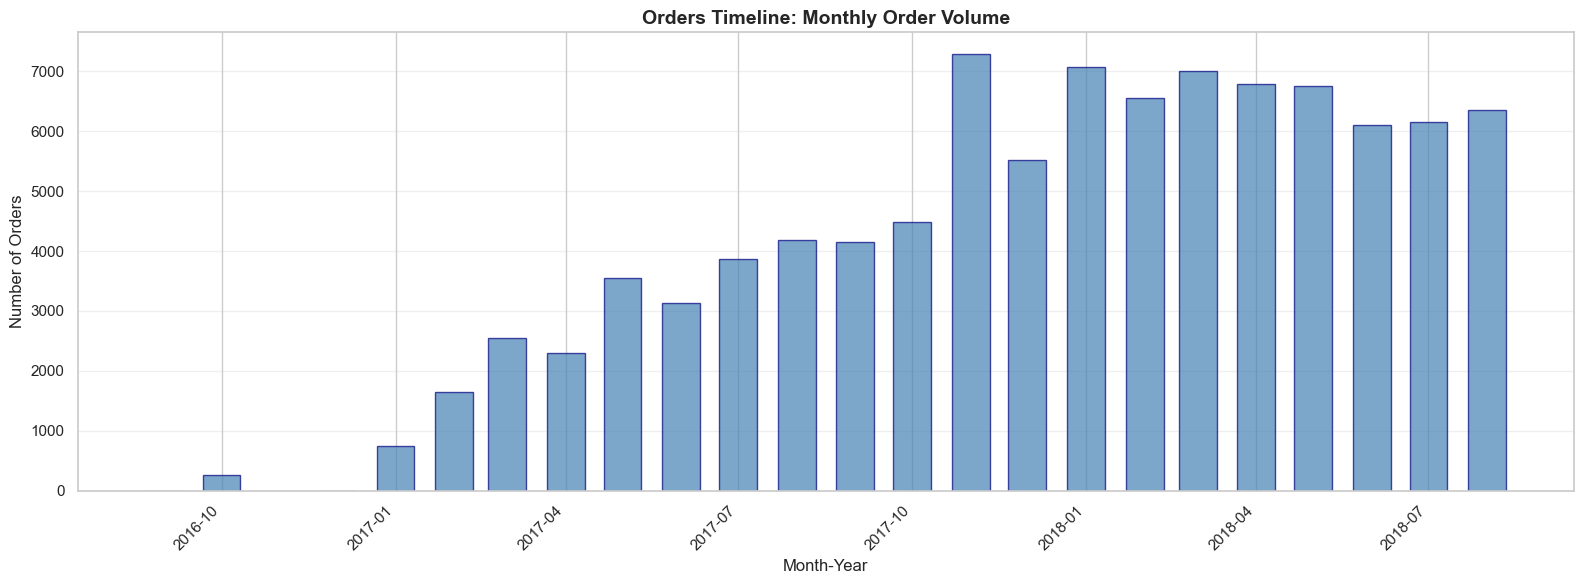


===== MONTHLY ORDER STATISTICS =====
Total orders: 96478
Average orders/month: 4195
Peak month: 2017-11 (7289 orders)
Lowest month: 2016-09 (1 orders)

Month-by-Month Breakdown:
year_month  order_count
   2016-09            1
   2016-10          265
   2016-12            1
   2017-01          750
   2017-02         1653
   2017-03         2546
   2017-04         2303
   2017-05         3546
   2017-06         3135
   2017-07         3872
   2017-08         4193
   2017-09         4150
   2017-10         4478
   2017-11         7289
   2017-12         5513
   2018-01         7069
   2018-02         6555
   2018-03         7003
   2018-04         6798
   2018-05         6749
   2018-06         6099
   2018-07         6159
   2018-08         6351

===== DELAY BREAKDOWN ANALYSIS =====

Total delivered orders analyzed: 96469

--- Seller Delay (Order Placed to Carrier Pickup) ---
count    96469.000000
mean         2.736402
std          3.611423
min       -172.000000
25%          1.000000
50

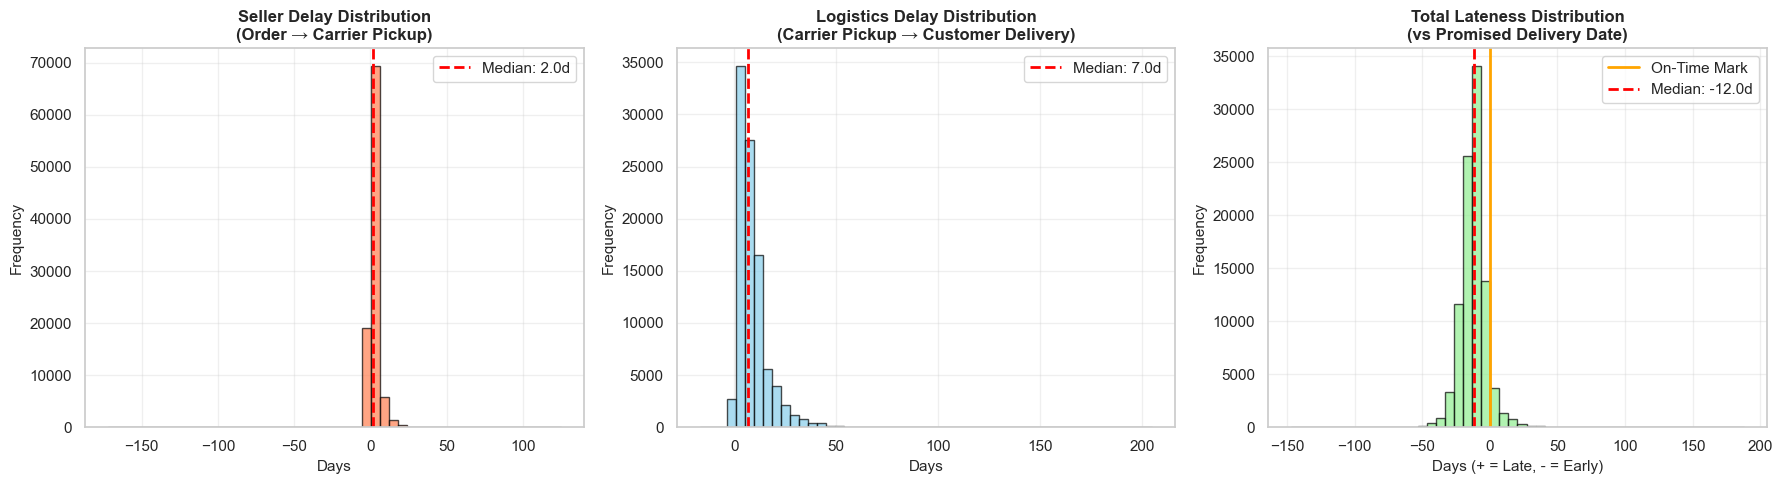

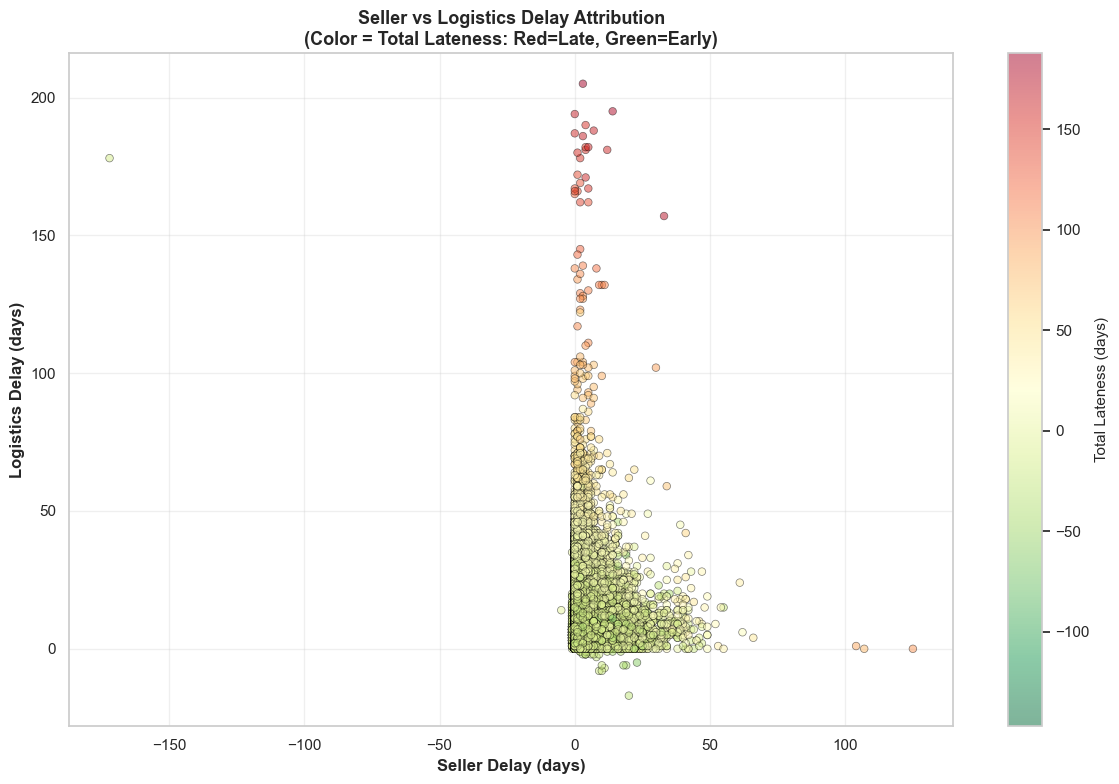

/var/folders/s8/422ypdc50wl56c902xtkhn000000gn/T/ipykernel_20765/3745314156.py:195: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lateness_by_seller_delay = delivery_analysis.groupby('seller_delay_bucket')['total_lateness_days'].agg([


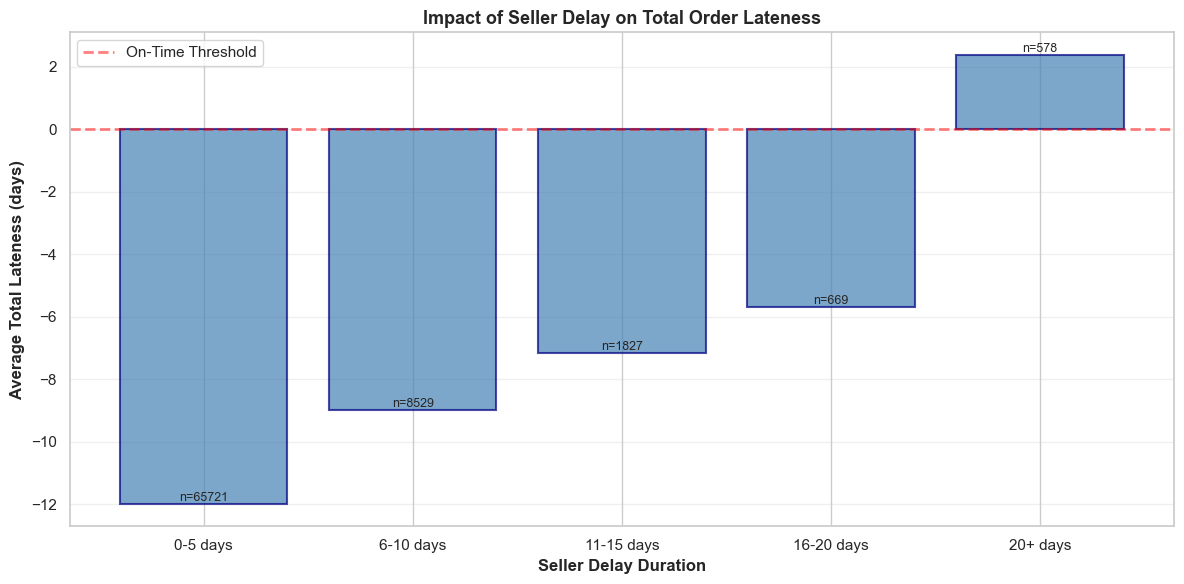


📈 Data for the bar chart:
seller_delay_bucket       mean  median       std  count
           0-5 days -11.987614   -13.0  9.785950  65721
          6-10 days  -8.974088    -9.0 10.786699   8529
         11-15 days  -7.176793    -7.0 13.954195   1827
         16-20 days  -5.705531    -4.0 14.782201    669
           20+ days   2.384083     4.0 19.689828    578


===== SUMMARY: DELAY ATTRIBUTION =====

Average Delays:
  Seller Delay (Order → Carrier):        2.7 days
  Logistics Delay (Carrier → Customer):  8.9 days
  Total Delay (if order is late):        10.6 days

Median Delays:
  Seller Delay (Order → Carrier):        2.0 days
  Logistics Delay (Carrier → Customer):  7.0 days
  Total Lateness (if order is late):     7.0 days

✅ INTERPRETATION:
  • High seller_lateness_corr → Sellers are slow at preparing/handing off orders
  • High logistics_lateness_corr → Carriers are slow in transit
  • Use this to decide: Should you optimize seller processes or negotiate with logistics partners?

In [146]:
# ============================================================================
# QUESTION 1: Orders by Month & Year Timeline (Bar Chart)
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure dates are datetime (should already be from earlier cells)
orders_master['order_purchase_timestamp'] = pd.to_datetime(orders_master['order_purchase_timestamp'])

# Extract year-month
orders_master['year_month'] = orders_master['order_purchase_timestamp'].dt.to_period('M')

# Count orders by month
orders_by_month = orders_master.groupby('year_month').size().reset_index(name='order_count')

# Convert back to timestamp for plotting
orders_by_month['year_month_ts'] = orders_by_month['year_month'].dt.to_timestamp()

# Create timeline bar chart
plt.figure(figsize=(16, 6))
plt.bar(orders_by_month['year_month_ts'], orders_by_month['order_count'], width=20, color='steelblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Orders Timeline: Monthly Order Volume', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary stats
print("\n===== MONTHLY ORDER STATISTICS =====")
print(f"Total orders: {orders_by_month['order_count'].sum()}")
print(f"Average orders/month: {orders_by_month['order_count'].mean():.0f}")
print(f"Peak month: {orders_by_month.loc[orders_by_month['order_count'].idxmax(), 'year_month']} ({orders_by_month['order_count'].max()} orders)")
print(f"Lowest month: {orders_by_month.loc[orders_by_month['order_count'].idxmin(), 'year_month']} ({orders_by_month['order_count'].min()} orders)")
print("\nMonth-by-Month Breakdown:")
print(orders_by_month[['year_month', 'order_count']].to_string(index=False))


# ============================================================================
# QUESTION 2: Seller Delay vs Total Lateness Correlation
# Attribution Analysis: Is lateness due to Seller or Freight?
# ============================================================================

import numpy as np

# Ensure all date columns are datetime
orders_master['order_purchase_timestamp'] = pd.to_datetime(orders_master['order_purchase_timestamp'])
orders_master['order_delivered_carrier_date'] = pd.to_datetime(orders_master['order_delivered_carrier_date'])
orders_master['order_delivered_customer_date'] = pd.to_datetime(orders_master['order_delivered_customer_date'])
orders_master['order_estimated_delivery_date'] = pd.to_datetime(orders_master['order_estimated_delivery_date'])

# Calculate delays in days
# Seller delay: Time from order placed to handoff to carrier
orders_master['seller_delay_days'] = (
    orders_master['order_delivered_carrier_date'] -
    orders_master['order_purchase_timestamp']
).dt.days

# Logistics delay: Time from carrier pickup to customer delivery
orders_master['logistics_delay_days'] = (
    orders_master['order_delivered_customer_date'] -
    orders_master['order_delivered_carrier_date']
).dt.days

# Total lateness: How many days late relative to promised date
orders_master['total_lateness_days'] = (
    orders_master['order_delivered_customer_date'] -
    orders_master['order_estimated_delivery_date']
).dt.days

# Filter to delivered orders only (to avoid NaT values)
delivery_analysis = orders_master[
    orders_master['order_status'] == 'delivered'
].copy()

# Remove rows with any NaT values in key columns
delivery_analysis = delivery_analysis.dropna(subset=[
    'seller_delay_days', 'logistics_delay_days', 'total_lateness_days'
])

print("\n===== DELAY BREAKDOWN ANALYSIS =====")
print(f"\nTotal delivered orders analyzed: {len(delivery_analysis)}")

print("\n--- Seller Delay (Order Placed to Carrier Pickup) ---")
print(delivery_analysis['seller_delay_days'].describe())
print(f"Median: {delivery_analysis['seller_delay_days'].median():.1f} days")
print(f"95th percentile: {delivery_analysis['seller_delay_days'].quantile(0.95):.1f} days")

print("\n--- Logistics Delay (Carrier Pickup to Customer Delivery) ---")
print(delivery_analysis['logistics_delay_days'].describe())
print(f"Median: {delivery_analysis['logistics_delay_days'].median():.1f} days")
print(f"95th percentile: {delivery_analysis['logistics_delay_days'].quantile(0.95):.1f} days")

print("\n--- Total Lateness (vs Promised Date) ---")
print(delivery_analysis['total_lateness_days'].describe())
print(f"Median: {delivery_analysis['total_lateness_days'].median():.1f} days")
print(f"% of orders that were late: {(delivery_analysis['total_lateness_days'] > 0).mean() * 100:.2f}%")
print(f"% of orders that were early: {(delivery_analysis['total_lateness_days'] < 0).mean() * 100:.2f}%")

# ===== CORRELATION ANALYSIS =====
print("\n\n===== CORRELATION: WHO'S RESPONSIBLE FOR LATENESS? =====")

correlation_matrix = delivery_analysis[[
    'seller_delay_days',
    'logistics_delay_days',
    'total_lateness_days',
    'distance_km'
]].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Focus on the key insight
seller_lateness_corr = delivery_analysis['seller_delay_days'].corr(delivery_analysis['total_lateness_days'])
logistics_lateness_corr = delivery_analysis['logistics_delay_days'].corr(delivery_analysis['total_lateness_days'])

print(f"\n📊 KEY FINDING:")
print(f"   Seller Delay ↔ Total Lateness:     {seller_lateness_corr:.4f}")
print(f"   Logistics Delay ↔ Total Lateness: {logistics_lateness_corr:.4f}")

if abs(seller_lateness_corr) > abs(logistics_lateness_corr):
    print(f"\n🎯 CONCLUSION: Seller delays are MORE correlated with total lateness")
    print(f"   → Seller handling is the primary driver of lateness issues")
else:
    print(f"\n🎯 CONCLUSION: Logistics delays are MORE correlated with total lateness")
    print(f"   → Freight/carrier is the primary driver of lateness issues")

# ===== VISUALIZATION 1: Distribution Comparison =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(delivery_analysis['seller_delay_days'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Days', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Seller Delay Distribution\n(Order → Carrier Pickup)', fontsize=12, fontweight='bold')
axes[0].axvline(delivery_analysis['seller_delay_days'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {delivery_analysis['seller_delay_days'].median():.1f}d")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(delivery_analysis['logistics_delay_days'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Days', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Logistics Delay Distribution\n(Carrier Pickup → Customer Delivery)', fontsize=12, fontweight='bold')
axes[1].axvline(delivery_analysis['logistics_delay_days'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {delivery_analysis['logistics_delay_days'].median():.1f}d")
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].hist(delivery_analysis['total_lateness_days'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Days (+ = Late, - = Early)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title(f'Total Lateness Distribution\n(vs Promised Delivery Date)', fontsize=12, fontweight='bold')
axes[2].axvline(0, color='orange', linestyle='-', linewidth=2, label='On-Time Mark')
axes[2].axvline(delivery_analysis['total_lateness_days'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {delivery_analysis['total_lateness_days'].median():.1f}d")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===== VISUALIZATION 2: Scatter Plot - Seller vs Logistics Delay =====
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    delivery_analysis['seller_delay_days'],
    delivery_analysis['logistics_delay_days'],
    c=delivery_analysis['total_lateness_days'],
    cmap='RdYlGn_r',  # Red = late, Yellow = on-time, Green = early
    alpha=0.5,
    s=30,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Seller Delay (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Logistics Delay (days)', fontsize=12, fontweight='bold')
ax.set_title('Seller vs Logistics Delay Attribution\n(Color = Total Lateness: Red=Late, Green=Early)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total Lateness (days)', fontsize=11)

plt.tight_layout()
plt.show()

# ===== VISUALIZATION 3: Average Lateness by Seller Delay Bucket =====
# Bucket seller delays to see impact
delivery_analysis['seller_delay_bucket'] = pd.cut(
    delivery_analysis['seller_delay_days'],
    bins=[0, 5, 10, 15, 20, 1000],
    labels=['0-5 days', '6-10 days', '11-15 days', '16-20 days', '20+ days']
)

lateness_by_seller_delay = delivery_analysis.groupby('seller_delay_bucket')['total_lateness_days'].agg([
    'mean', 'median', 'std', 'count'
]).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(lateness_by_seller_delay))
bars = ax.bar(x_pos, lateness_by_seller_delay['mean'],
              color='steelblue', alpha=0.7, edgecolor='navy', linewidth=1.5)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, lateness_by_seller_delay['count'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'n={int(count)}',
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Seller Delay Duration', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Total Lateness (days)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Seller Delay on Total Order Lateness', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(lateness_by_seller_delay['seller_delay_bucket'])
ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='On-Time Threshold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\n📈 Data for the bar chart:")
print(lateness_by_seller_delay.to_string(index=False))

# ===== SUMMARY TABLE =====
print("\n\n===== SUMMARY: DELAY ATTRIBUTION =====")
print("\nAverage Delays:")
print(f"  Seller Delay (Order → Carrier):        {delivery_analysis['seller_delay_days'].mean():.1f} days")
print(f"  Logistics Delay (Carrier → Customer):  {delivery_analysis['logistics_delay_days'].mean():.1f} days")
print(f"  Total Delay (if order is late):        {delivery_analysis[delivery_analysis['total_lateness_days'] > 0]['total_lateness_days'].mean():.1f} days")

print("\nMedian Delays:")
print(f"  Seller Delay (Order → Carrier):        {delivery_analysis['seller_delay_days'].median():.1f} days")
print(f"  Logistics Delay (Carrier → Customer):  {delivery_analysis['logistics_delay_days'].median():.1f} days")
print(f"  Total Lateness (if order is late):     {delivery_analysis[delivery_analysis['total_lateness_days'] > 0]['total_lateness_days'].median():.1f} days")

print("\n✅ INTERPRETATION:")
print("  • High seller_lateness_corr → Sellers are slow at preparing/handing off orders")
print("  • High logistics_lateness_corr → Carriers are slow in transit")
print("  • Use this to decide: Should you optimize seller processes or negotiate with logistics partners?")
